In [1]:
import nltk
from nltk.stem.porter import PorterStemmer
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
from googlesearch import search
import requests
import json
import webbrowser

In [2]:
stemmer = PorterStemmer()

def tokenize(setence):
    return nltk.word_tokenize(setence)

def stem(word):
    return stemmer.stem(word.lower()) 

def bag_of_words(tokenize_sentence, all_words):
    tokenize_sentence = [stem(w) for w in tokenize_sentence]
    bag = np.zeros(len(all_words))
    for index, word in enumerate(all_words):
        if word in tokenize_sentence:
            bag[index] = 1.0
    return bag

In [3]:
with open('content.json','r') as f:
    contents = json.load(f)

In [4]:
all_words = []
tags = []
xy = []

In [5]:
for content in contents['intents']:
    tag = content['tag']
    tags.append(tag)
    for pattern in content['patterns']:
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w,tag))

In [6]:
ignore = ['!','?','.',',','/','@','$','%','&']

In [7]:
all_words = [stem(w) for w in all_words if w not in ignore]

In [8]:
all_words = sorted(set(all_words))
tags = sorted(set(tags))

In [9]:
x_train, y_train = [], []
for pattern, tag in xy:
    x_train.append(bag_of_words(pattern,all_words))    
    y_train.append(tags.index(tag))

In [10]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [12]:
class ChatBotData(Dataset):
    
    def __init__(self):
        self.length = len(x_train)
        self.data = x_train
        self.labels = y_train
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    
    def __len__(self):
        return self.length

In [13]:
data = ChatBotData()
train_loader = DataLoader(dataset=data, batch_size=4, shuffle=True)

In [14]:
def get_activation(activation):
    return activation()

In [15]:
class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, n_class, activation):
        super(NeuralNet,self).__init__()
        self.l1 = nn.Linear(input_size,hidden_size)
        self.l2 = nn.Linear(hidden_size,hidden_size)
        self.l3 = nn.Linear(hidden_size,n_class)
        self.activation = get_activation(activation)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.activation(out)
        out = self.l2(out)
        out = self.activation(out)
        out = self.l3(out)
        
        return out

In [16]:
input_size = x_train.shape[1]
hidden_size = 256
n_class = len(tags)

In [17]:
model = NeuralNet(input_size,hidden_size,n_class,nn.ReLU)

In [18]:
class train_model():
    
    def __init__(self,model):
        self.model = model
        self.training_loss = []
        
    def compile(self, lr=1e-3, loss=nn.CrossEntropyLoss(),optimizer=torch.optim.Adam):  
        self.loss_module = loss
        self.optimizer = optimizer(self.model.parameters(),lr=lr)
   
    def fit(self, train_loader):

        self.model = self.model.train()
        total_loss = 0
        total_batch_accuracy = 0

        for i, batch in enumerate(train_loader):
            x_train, y_train = batch
            prediction = self.model(x_train.float())
            loss = self.loss_module(prediction, y_train)
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=4.0)
            self.optimizer.step()

            total_loss += loss
            mean_batch_loss = total_loss/(i+1)

            predictions = torch.argmax(prediction, 1)
            batch_accuracy = accuracy_score(y_train, predictions)

            
            total_batch_accuracy += batch_accuracy 
            mean_bach_accuracy = total_batch_accuracy/(i+1)
            
        return mean_batch_loss.detach().numpy(), mean_bach_accuracy
        
         
    def train(self,train_loader,epochs=100,verbose=True,return_loss=True,early_stopping=10):
               
        best_loss = np.inf
        early_stop_counter = 0
        
        for epoch in range(epochs):
    
            loss, batch_accuracy = self.fit(train_loader)
            
            self.training_loss.append(loss)
          
            
            
            if verbose:
                print('\033[94m'+'Epoch: {}'.format(epoch)+'\033[0m'+' {}%'.format(round(batch_accuracy*100,3)),
                  '\033[91m'+'loss:'+'\033[0m'+' {}'.format(round(float(loss),4)),
                 # '\033[94m Val:'+'\033[0m'+' {}'.format(round(val_batch_accuracy*100,3)),
                  #'\033[91m'+'val_loss:'+'\033[0m'+' {}'.format(round(float(val_loss),4))
                 )
      

        if return_loss:
            plt.plot(self.training_loss)
        
    def predict(self):
        pass

In [19]:
model_train = train_model(model)

In [20]:
model_train.compile()

Epoch: 0 4.31% loss: 3.4319
Epoch: 1 18.103% loss: 3.295
Epoch: 2 26.724% loss: 3.0695
Epoch: 3 25.0% loss: 2.7155
Epoch: 4 45.69% loss: 2.2452
Epoch: 5 59.483% loss: 1.6706
Epoch: 6 68.966% loss: 1.2794
Epoch: 7 84.483% loss: 0.9263
Epoch: 8 92.241% loss: 0.6564
Epoch: 9 93.103% loss: 0.5056
Epoch: 10 96.552% loss: 0.3454
Epoch: 11 98.276% loss: 0.2312
Epoch: 12 97.414% loss: 0.1634
Epoch: 13 97.414% loss: 0.1192
Epoch: 14 98.276% loss: 0.0925
Epoch: 15 99.138% loss: 0.0696
Epoch: 16 98.276% loss: 0.0714
Epoch: 17 99.138% loss: 0.0557
Epoch: 18 98.276% loss: 0.0606
Epoch: 19 99.138% loss: 0.0437
Epoch: 20 98.276% loss: 0.0361
Epoch: 21 99.138% loss: 0.0378
Epoch: 22 98.276% loss: 0.0423
Epoch: 23 99.138% loss: 0.0349
Epoch: 24 99.138% loss: 0.0412
Epoch: 25 99.138% loss: 0.0392
Epoch: 26 99.138% loss: 0.0407
Epoch: 27 99.138% loss: 0.0263
Epoch: 28 99.138% loss: 0.034
Epoch: 29 99.138% loss: 0.0229
Epoch: 30 98.276% loss: 0.0375
Epoch: 31 98.276% loss: 0.0424
Epoch: 32 99.138% loss: 0

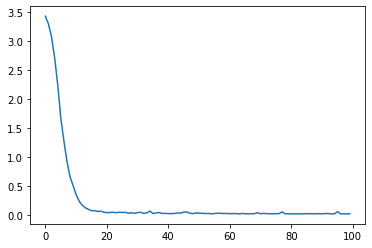

In [21]:
model_train.train(train_loader)

In [22]:
model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [23]:
model.eval()

NeuralNet(
  (l1): Linear(in_features=120, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=31, bias=True)
  (activation): ReLU()
)

In [105]:
def get_response(return_list,intents_json):
    
    if len(return_list)==0:
        tag='noanswer'
    else:    
        tag=return_list[0]['intent']
    if tag=='datetime':        
        print(time.strftime("%A"))
        print (time.strftime("%d %B %Y"))
        print (time.strftime("%H:%M:%S"))

    if tag=='google':
        query=input('Enter query...')
        for url in search(query, tld="com", num=1, stop = 1, pause = 2):
            webbrowser.get('chrome').open_new_tab("https://google.com/search?q=%s" % query)
            
    if tag=='weather':
        api_key='4b2ebcea542908562c6acffd8b67522c'
        base_url = "http://api.openweathermap.org/data/2.5/weather?"
        city_name = input("Enter city name : ")
        complete_url = base_url + "appid=" + api_key + "&q=" + city_name
        response = requests.get(complete_url) 
        x=response.json()
        print('Present temp.: ',round((x['main']['temp'] - 273.15) * 9/5 + 32,2),'Fahrenheitweather')
        print('Feels Like:: ',round((x['main']['feels_like'] - 273.15) * 9/5 + 32,2),'Fahrenheit')
        print(x['weather'][0]['main'])
        
    if tag=='news':
        
        main_url = "https://gnews.io/api/v4/top-headlines?lang=en&country=us&token=fe0f83fece244fcacbe50315ad121b57"
        open_news_page = requests.get(main_url).json()
        article = open_news_page["articles"]
        results = [] 
          
        for ar in article: 
            results.append([ar["title"],ar["url"]]) 
          
        for i in range(10): 
            print(i + 1, results[i][0])
            print(results[i][1],'\n')
            

    list_of_intents= intents_json['intents']    
    for i in list_of_intents:
        if tag==i['tag'] :
            result= random.choice(i['responses'])
    return print(result)



In [106]:
def predict(sentence,model):
    sentence = tokenize(sentence)
    x = bag_of_words(sentence,all_words)
    x = x.reshape(1,x.shape[0])
    x = torch.from_numpy(x)
    
    output = model(x.float())
    prediction = torch.argmax(output, axis=1)
    tag = tags[prediction.item()]
    probs = torch.softmax(output,dim=1)
    output_list=[[i,r] for i,r in enumerate(probs[0]) if r>0.7]
    output_list.sort(key=lambda x: x[1],reverse=True)
    suggetions = []
    
    for out in output_list:
        suggetions.append({'intent':tags[out[0]],'prob':str(out[1].item())})
    #return suggetions
    probs = torch.softmax(output,dim=1)
    prob = probs[0][prediction.item()]

    if prob.item()>0.6:
        for content in contents['intents']:
            if tag == content['tag']:
                print(f"{bot_name}: {random.choice(content['responses'])}")
    else:
        print(f"{bot_name}: Sorry, I didn't get it.")

In [111]:
bot_name = 'Jarvis'
print(f'{bot_name}: Hi, How may I help you today!')
while True:
    sentence = input('You: ')
    if sentence == 'quit':
        print(f'{bot_name}: Have a great day, Thank you')
        break
        
    predict(sentence,model)

Jarvis: Hi, How may I help you today!
You: Hey
Jarvis: Hi, how may I help you today?
You: How are you doing today
Jarvis: All good..What about you?
You: WHats up
Jarvis: All good..What about you?
You: Fuck you
Jarvis: Sorry, I didn't get it.
You: greetings
Jarvis: Sorry, I didn't get it.
You: google
Jarvis: Redirecting to Google...
You: whats the date today
Jarvis: Date and Time
You: datetime
Jarvis: Sorry, I didn't get it.


KeyboardInterrupt: Interrupted by user

In [ ]:
'google':
query=input('Enter query...')
for url in search(query, tld="com", num=1, stop = 1, pause = 2):
    webbrowser.get('chrome').open_new_tab("https://google.com/search?q=%s" % query)


In [ ]:
webbrowser.get('chrome').open_new_tab("https://google.com/search?q=%s" % query)

In [137]:
api_key='4b2ebcea542908562c6acffd8b67522c'
base_url = "http://api.openweathermap.org/data/2.5/weather?"
city_name = input("Enter city name : ")
complete_url = base_url + "appid=" + api_key + "&q=" + city_name
response = requests.get(complete_url) 

Enter city name : New Jersey


In [138]:
x=response.json()

In [139]:
def temp_change(x):
    return ((9*(x-273))/5)+32


In [140]:
temp_change(x['main']['temp'])

44.95999999999998